In [15]:
import numpy as np
import os
import math
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation as animation

# Report

## code documentation

First, I will introduce the flow of the code:
* MPI initialize, p, id
* according to the process number p, divide the grid into rectangular domains. `find_dimensions(p, rows, columns)`
* according to process id, obtain its indices in divided domain grid. `id_to_index(id, id_row, id_column)`
* allocate grid for current process id, the grid size is rectangular subdomain with two extra ghost rows and columns. `allocate_grid(grid, new_grid, old_grid, imax, jmax, grid_rows, grid_columns)`
* construct the MPI data type for communications, the sending type are the four edges in data_array, the recving type are four edges in recv_array. In communications, only the edge data is send. `createdatatypes(data_array, m, n)`, `createdatatypes_recv(recv_array, l, k)`
* program main procedure loop: process sends its edge to neighbour processes(if it exists), and waits for all its existed neighbors edge data. Then, after recving all edge data, process copy the edge data to grid array (`copy_boundry(grid, l, k, recv_array, recv_left, recv_top, recv_right, recv_bottom)`) and perform the calculation for new_gird using grid and old_grid(`do_iteration()`). In the end, process writes output if it should for this iteration(`grid_to_file(id, out_cnt, grid)`).
    

Each method documentation:

### void find_dimensions(int p, int &rows, int &columns)
This method is used to calculate the rows and columns of processes. For example, if p is 4, it will make $rows=2, columns=2$. It arranges the process as close to the square as possible.

### void id_to_index(int id, int &id_row, int &id_column)
This method is used to get the row id and column id by the process id. For example, the ids assigned to 4 processes is shown as below. The ids start from 0 to p-1, which are allocated along the rows.

![jupyter](./img/1.png)

### int id_from_index(int id_row, int id_column)
This method is used to get the process id by the row id and column id, which is the inverse operation to last method.

### void allocate_grid( )
parameter: vector< vector<double> > &grid, vector< vector<double> > &new_grid, vector< vector<double> > &old_grid, int imax, int jmax, int &grid_rows, int &grid_columns
    
This method is used to allocate the subgrid to each process. The rows and columns of each subgird is average value of the whole domain with extra two rows and two columns(ghost layers for communication). If there are remaining rows and columns when the whole domain is equally allocated to each process, the remaining row and columns are allocated to rightmost and bottommost side processes. For example, the whole domain $101\times101$ is allocated 4 processes above, the allocated result is:

* process 0: $50\times50$
* process 1: $50\times51$
* process 2: $51\times50$
* process 3: $51\times51$
    
This method assigns the value to gird and old_grid. Meanwhile, it support an overall domain of arbitrary size, which it can change the height and width of domain independently of one another.

### void init( )
parameter: vector< vector<double> > &grid, vector< vector<double> > &old_grid, double dx, double dy, int id_row, int id_column, int grid_rows, int grid_columns

This method is used to sets half sinusoidal intitiak disturbance for subdomain for its corresponding position in the entire domain.

### void grid_to_file(int id, int out, vector< vector<double> > &grid)
Write the gird value to output file for this process, not write the ghost layer.

### void createdatatypes(double** data, int m, int n)
Create the MPI data type for sending, which is Datatype_left, Datatype_right, Datatype_top, Datatype_bottom. The four data type correspond to the four edge of data_array.

### void createdatatypes_recv(double** data, int m, int n)
Create the MPI data type for receiving, which is Datatype_left_recv, Datatype_right_recv, Datatype_top_recv, Datatype_bottom_recv. The four data type correspond to the four edge of recv_array.

### void copy_boundry( )
parameter: vector< vector<double> > &grid, int recv_array_rows, int recv_array_columns, double** recv_array, bool recv_left, bool recv_top, bool recv_right, bool recv_bottom
    
Copy the data of edges in recv_array to gird(only copy the edge it received, not all four edges).

### void do_iteration( )
Perform the calculation for new_gird using grid and old_grid, and set the boundry value(Neumann boundaries) if process is in boundry.

## Result

This example uses gird size $100\times100$ and 4 cores, the other parameters: $tmax=30, x\_max = 10, y\_max=10, c=1$ and runs in local no HPC. 
The output in terminal is shown as below:
![jupyter](./img/2.png)

To combine the output files, visualize it and to see dynamic image, please run the following cell again.
The output file combination and visualization will take some time, please be patient, the GIF will be displayed in this file and saved in the current folder named 'dynamic image.gif'.

files combining...
files combined finished!
gif generating...


<IPython.core.display.Javascript object>


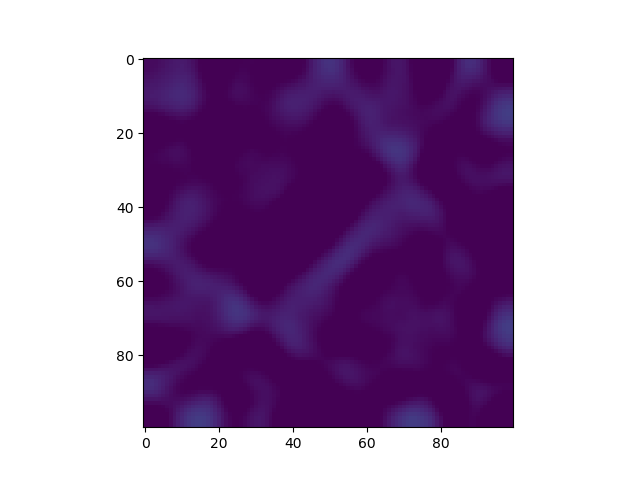

gif generation finished and saved in folder!


In [20]:
# %matplotlib notebook

path = "./out_parallel"

p_num = 4

filenames = os.listdir(path)

output_num = int(len(filenames) / p_num)

def find_dimensions(p):
    min_gap = p;
    top = int(math.sqrt(p) + 1);
    for i in range(1, top+1):
        if (p % i == 0):
            gap = abs(p / i - i);

            if (gap < min_gap):
                min_gap = gap;
                rows = i;
                columns = p / i;
        
    return int(rows), int(columns)

rows, columns = find_dimensions(p_num)
        
print("files combining...")
    
# 输出output_num文件
for it in range(output_num):
    fname = "./out_parallel_combined/output_" + str(it) + ".dat"
    
    
    df_file = pd.DataFrame()
    
    df_list = [rows, columns]
    
    # 每行一个
    for i in range(0, rows):
        df_list[i] = []
        for j in range(0, columns):
            p_id = i*columns+j
            file_path = path + '/output_' + str(it) + '_p' + str(p_id) + '.dat'
            df = pd.read_table(file_path, sep = '\t', header = None)
            df_list[i].append(df)
            df.drop(df.columns[len(df.columns)-1], axis=1, inplace=True)

    df_img = pd.DataFrame()
    
    # 拼接
    for i in range(0, rows):
        df_row = pd.DataFrame()
        for j in range(0, columns):
            df_row = pd.concat([df_row,df_list[i][j]], axis=1, ignore_index=True)
        df_img = pd.concat([df_img, df_row], ignore_index=True)
        
            
    df_img.to_csv(fname, sep='\t',index=0, header=0)
    

print("files combined finished!")
print("gif generating...")

    
"""
=================
An animated image
=================
This example demonstrates how to animate an image.
"""
%matplotlib notebook
fig = plt.figure()

img_list = []

for i in range(output_num):
    df =  pd.read_table("./out_parallel_combined/output_"+ str(i) +".dat", header=None)
    data = df.values
    img_list.append(data)
    
img_num = len(img_list)

im = plt.imshow(img_list[0], animated=True)

def updatefig(frame,*args):
    im.set_array(img_list[frame])
    return im

ani = animation.FuncAnimation(fig, updatefig, frames=img_num, interval=50, blit=True)
ani.save('dynamic image.gif', writer='pillow')
plt.show()
print("gif generation finished and saved in folder!")

## Performance

I use the HPC system to test the performance of code with the size of the problem and the number of cores used. First I changed the number of cores used in three different grid sizes($100\times100$). The performance is shown as below.

<IPython.core.display.Javascript object>


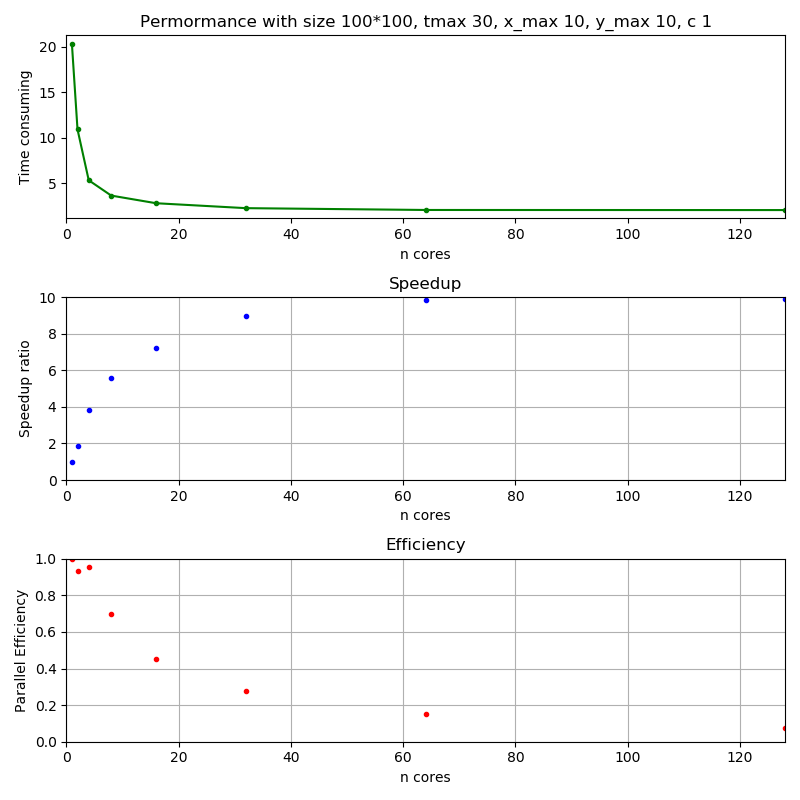

In [86]:
x = np.array([1, 2, 4, 8, 16, 32, 64, 128])
y_100 = np.array([20.32, 10.91, 5.33, 3.65, 2.81, 2.27, 2.07, 2.06])
speedup_ratio = y_100[0] / y_100
efficiency = speedup_ratio / x 

fig, ax = plt.subplots(3, 1, figsize=(8, 8))

# size 100*100, tmax 30, x_max = 10, y_max=10, c=1
ax[0].plot(x, y_100, 'g.-', label="size 100*100")
# ax[0].plot(x, speedup_ratio, 'b.-', label="size 100*100")
# ax[0].plot(x, efficiency, 'b.-', label="size 100*100")
ax[0].set_xlim(0,128)
ax[0].set_xlabel('n cores')
ax[0].set_ylabel('Time consuming')
ax[0].set_title('Permormance with size 100*100, tmax 30, x_max 10, y_max 10, c 1')

ax[1].plot(x, speedup_ratio, 'b.', label="size 100*100")
ax[1].set_xlim(0,128)
ax[1].set_ylim(0,10)
ax[1].set_xlabel('n cores')
ax[1].set_ylabel('Speedup ratio')
ax[1].set_title('Speedup')
ax[1].grid()

ax[2].plot(x, efficiency, 'r.', label="size 100*100")
ax[2].set_xlim(0,128)
ax[2].set_ylim(0,1)
ax[2].set_xlabel('n cores')
ax[2].set_ylabel('Parallel Efficiency')
ax[2].set_title('Efficiency')
ax[2].grid()

fig.tight_layout()

By observating the plots, with the cores used increasing, initially it has a exercellant effect on imporving performance and the parallel efficiency is approximately to one. However, as the number of cores used increase, the parallel efficiency will drop. The speedup is initially linear but later the rate of growth is slowing down.

Then, by keeping the number of codes used(here is 8 cores), I change the size of grid and the performance is shown as below.

<IPython.core.display.Javascript object>


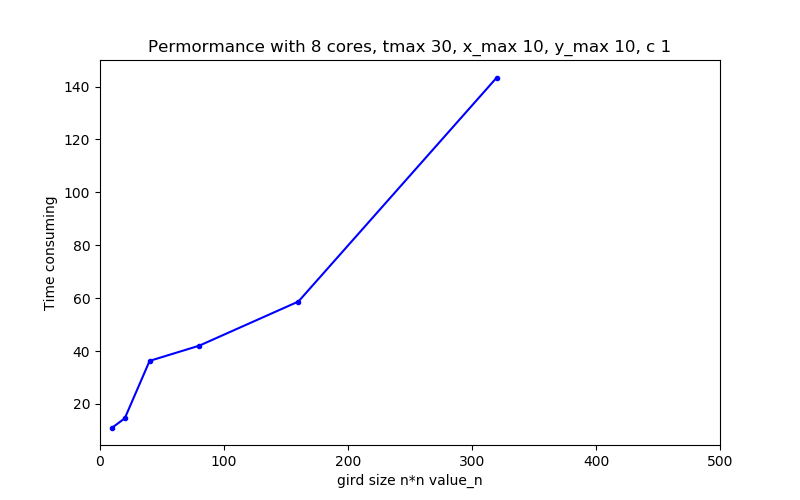

Text(0.5, 1.0, 'Permormance with 8 cores, tmax 30, x_max 10, y_max 10, c 1')

In [88]:
x = np.array([10, 20, 40, 80, 160, 320])
y = np.array([11.07, 14.56, 36.26, 42.01, 58.71, 143.44])

fig, ax = plt.subplots(1, 1, figsize=(8, 5))

# size 100*100, tmax 30, x_max = 10, y_max=10, c=1
ax.plot(x, y, 'b.-')
ax.set_xlim(0,500)
ax.set_xlabel('gird size n*n value_n')
ax.set_ylabel('Time consuming')
ax.set_title('Permormance with 8 cores, tmax 30, x_max 10, y_max 10, c 1')

It is obvious that with increasement of grid size, it will take more and more time for fixed cores.

Then I change the height and width of the domain independtly of one another with the parameter(tmax 30, x_max 10, y_max 10, c 1):

<IPython.core.display.Javascript object>


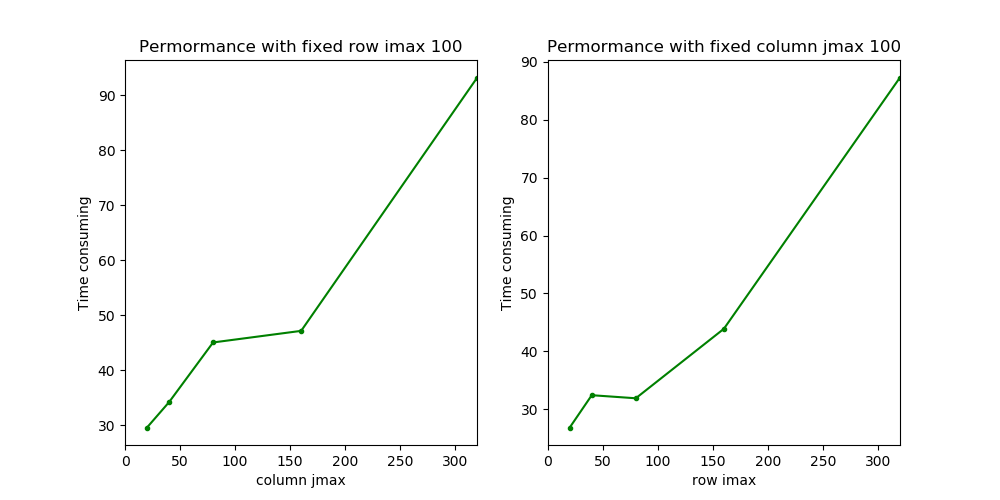

Text(0.5, 1.0, 'Permormance with fixed column jmax 100')

In [41]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

x = np.array([20, 40, 80, 160, 320])
y_rowfixed = np.array([29.55, 34.16, 45.03, 47.14, 93.26])
y_columnfixed = np.array([26.83, 32.41, 31.88, 43.88, 87.3])

# size 100*100, tmax 30, x_max = 10, y_max=10, c=1
ax[0].plot(x, y_rowfixed, 'g.-', label="size 100*100")
ax[0].set_xlim(0,320)
ax[0].set_xlabel('column jmax')
ax[0].set_ylabel('Time consuming')
ax[0].set_title('Permormance with fixed row imax 100')

ax[1].plot(x, y_columnfixed, 'g.-', label="size 100*100")
ax[1].set_xlim(0,320)
ax[1].set_xlabel('row imax')
ax[1].set_ylabel('Time consuming')
ax[1].set_title('Permormance with fixed column jmax 100')

For the domain decomposition, dividing the simulation into rectangular domains that as close to square as possible make the domain decomposition more efficient.